In [ ]:
!pip install opendatasets

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 45.6 MB/s eta 0:00:00


In [ ]:
import torch
import math
import base64
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision.utils import make_grid
from PIL import Image
import os
import cv2
import gc
from torch.optim import Adam,AdamW
from dataclasses import dataclass
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as tf
from torchvision import datasets
import opendatasets as od
from torchvision.datasets import ImageFolder
from torch.cuda import amp
from torchmetrics import MeanMetric
from tqdm import tqdm
from datetime import datetime
from IPython.display import display, HTML, clear_output

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rupapriyanaskar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:22<00:00, 18.7MB/s]


# Building UNet

In [ ]:
class AttentionBlock(nn.Module):
  def __init__(self,channels = 64):
    super().__init__()
    self.channels = channels
    self.groupnorm = nn.GroupNorm(num_groups = 8, num_channels = self.channels)
    self.multi_head_attention = nn.MultiheadAttention(embed_dim = self.channels, num_heads= 4,batch_first = True)

  def forward(self,x):
    batch,_,height,width = x.shape
    out = self.groupnorm(x)
    out = out.reshape(batch,self.channels,height*width).transpose(1,2)
    out,_ = self.multi_head_attention(out,out,out)
    out = out.transpose(1,2).view(batch,self.channels,height,width)
    out = out + x
    return out


In [ ]:
class ResnetBlock(nn.Module):
  def __init__(self,in_channels,out_channels,time_emb_dims = 512,apply_attention = False,dropout_rate = 0.1):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.dropout_rate = dropout_rate
    self.apply_attention = apply_attention
    self.time_emb_dims = time_emb_dims

    self.act_func = nn.SiLU()
    self.norm_1 = nn.GroupNorm(num_groups = 8,num_channels = self.in_channels)
    self.conv_1 = nn.Conv2d(in_channels = self.in_channels, out_channels = self.out_channels,kernel_size = 3, stride = 1, padding = "same")

    #for time embedding
    self.dense_1 = nn.Linear(in_features = self.time_emb_dims,out_features = self.out_channels)
    self.norm_2 = nn.GroupNorm(num_groups = 8,num_channels = self.out_channels)
    self.dropout = nn.Dropout(p = self.dropout_rate)
    self.conv_2 = nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels,kernel_size = 3, padding = "same")

    if self.in_channels != self.out_channels:
      self.residual = nn.Conv2d(in_channels = self.in_channels, out_channels = self.out_channels,kernel_size = 1,padding = 0)
    else:
      self.residual = nn.Identity()

    if self.apply_attention:
      self.attention = AttentionBlock(channels = self.out_channels)
    else:
      self.attention = nn.Identity()

  #time embedding would be given as input
  def forward(self,x,t):
    out = self.conv_1(self.act_func(self.norm_1(x)))
    out += self.dense_1(self.act_func(t))[:, :, None, None]
    out = self.act_func(self.norm_2(out))
    out = self.dropout(out)
    out = self.conv_2(out)
    out += self.residual(x)
    out = self.attention(out)
    return out



In [ ]:
class DownSample(nn.Module):
  def __init__(self,channels):
    super().__init__()
    self.channels = channels
    self.conv = nn.Conv2d(in_channels=self.channels,out_channels = self.channels,kernel_size = 3,stride = 2,padding = 1)

  def forward(self,x,*args):
    return self.conv(x)

In [ ]:
class UpSample(nn.Module):
  def __init__(self,channels):
    super().__init__()
    self.channels = channels
    self.upsample = nn.Upsample(scale_factor = 2,mode = "nearest")
    self.conv = nn.Conv2d(in_channels = channels, out_channels = channels,kernel_size=3,padding = 1)

  def forward(self,x,*args):
    return self.conv(self.upsample(x))

In [ ]:
class SinusoidalPositionalEmbeddings(nn.Module):
  def __init__(self,time_emb_dims = 128, time_embedding_dims_exp = 512,total_time_steps = 1000):
    super().__init__()
    self.total_time_steps = total_time_steps
    self.ts = torch.arange(self.total_time_steps,dtype=torch.float32)
    self.time_emb_dims = time_emb_dims
    self.time_emb_dims_exp = time_embedding_dims_exp
    self.half_dim = self.time_emb_dims // 2
    # self.omegas = torch.exp(-(torch.log(torch.tensor(10000))/(self.half_dim - 1))*torch.arange(0,self.half_dim))
    self.omegas = torch.exp(-(math.log(10000)/(self.half_dim - 1)) * torch.arange(self.half_dim,dtype = torch.float32))

    self.omegas = self.omegas.unsqueeze(dim  = 0)
    self.ts = self.ts.unsqueeze(dim = -1)
    self.omega_t = self.ts @ self.omegas
    sin_val = torch.sin(self.omega_t)
    cos_val = torch.cos(self.omega_t)
    self.embedding_sinusoidal = torch.concat([sin_val,cos_val], dim = -1)
    self.time_block = nn.Sequential(
        nn.Embedding.from_pretrained(self.embedding_sinusoidal),
        nn.Linear(in_features = self.time_emb_dims,out_features = self.time_emb_dims_exp),
        nn.SiLU(),
        nn.Linear(in_features=self.time_emb_dims_exp,out_features=self.time_emb_dims_exp),
    )

  def forward(self,time):
    return self.time_block(time)



In [ ]:
# time is inherently involved in resnet block
class UNet(nn.Module):
  def __init__(self,time_emb_dims = 512,in_channels = 3,out_channels = 3,apply_attention = (False,False,True,False),base_channels = 128,no_res_block = 2,dropout_rate = 0.1,base_multiplier = (1,2,4,8) ):
    super().__init__()
    self.time_emb_dims = time_emb_dims
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.base_channels = base_channels
    self.apply_attention = apply_attention
    self.no_res_block = no_res_block
    self.base_multiplier = base_multiplier
    self.dropout_rate = dropout_rate

    #time_embedding
    self.time_embedding = SinusoidalPositionalEmbeddings(time_emb_dims = self.base_channels,time_embedding_dims_exp=self.time_emb_dims)

    #first conv layer to conver ch = 3 to cha = 128
    self.first_conv = nn.Conv2d(in_channels=self.in_channels,out_channels=self.base_channels,kernel_size = 3,stride = 1,padding = "same")

    no_of_resolution = len(self.base_multiplier)
    #building encoder
    self.encoder_blocks = nn.ModuleList()
    curr_channel = [base_channels]
    in_channels = base_channels
    #feed this into resnet block
    for level in range(no_of_resolution):
      out_channels = self.base_channels * self.base_multiplier[level]
      for _ in range(self.no_res_block):
        block = ResnetBlock(in_channels = in_channels,out_channels = out_channels,apply_attention=self.apply_attention[level],time_emb_dims = self.time_emb_dims)
        self.encoder_blocks.append(block)
        in_channels = out_channels
        curr_channel.append(in_channels)

      if level != (no_of_resolution-1):
        self.encoder_blocks.append(DownSample(channels = in_channels))
        curr_channel.append(in_channels)

    #building bottole neck
    self.bottoleneck_blocks = nn.ModuleList(
        (
            ResnetBlock(in_channels = in_channels,out_channels = in_channels,dropout_rate=self.dropout_rate,apply_attention = True,time_emb_dims=self.time_emb_dims),

            ResnetBlock(in_channels = in_channels,out_channels = in_channels,dropout_rate=self.dropout_rate,apply_attention = False,time_emb_dims=self.time_emb_dims),
        )
    )

    #Building decoder block
    self.decoder_block = nn.ModuleList()
    for level in reversed(range(no_of_resolution)):
      out_channels = self.base_channels * self.base_multiplier[level]
      for _ in range(self.no_res_block +1):
        encoder_channels = curr_channel.pop()
        block = ResnetBlock(
                            in_channels = encoder_channels + in_channels,
                            out_channels=out_channels,
                            time_emb_dims = self.time_emb_dims,
                            apply_attention = self.apply_attention[level],
                            dropout_rate= self.dropout_rate)

        in_channels = out_channels
        self.decoder_block.append(block)

      if level != 0:
        self.decoder_block.append(UpSample(channels = in_channels))

    #final block for batchnorm and others transformation
    self.final = nn.Sequential(
        nn.GroupNorm(num_groups = 8,num_channels = in_channels),
        nn.SiLU(),
        nn.Conv2d(in_channels = in_channels,out_channels = self.out_channels,kernel_size = 3,padding = "same",stride = 1)
    )

  def forward(self,t,x):
    time_embedding = self.time_embedding(t)
    out = self.first_conv(x)
    results = [out]

    for layer in self.encoder_blocks:
      out = layer(out,time_embedding)
      results.append(out)

    for layer in self.bottoleneck_blocks:
      out = layer(out,time_embedding)

    for layer in self.decoder_block:
      if isinstance(layer,ResnetBlock):
        encoder_layer = results.pop()
        out = torch.concat([out,encoder_layer],dim = 1)
      out = layer(out,time_embedding)

    out = self.final(out)
    return out

# Building Helper Functions

In [ ]:
def get_default_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking = True)

In [ ]:
class DeviceDataLoader():
  def __init__(self,device,dl):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
def save_images(images,path,**kwargs):
  grid_img  = make_grid(images,**kwargs)
  #convert the image to pil image
  grid_img = grid_img.permute(1,2,0).to("cpu").numpy()
  img = Image.fromarray(grid_img)
  img.save(path)

def setup_log_directory(config):
  if os.path.isdir(config.root_log_dir):
    folder_no = [int(folder.replace("version_","")) for folder in os.listdir(config.root_log_dir)]
    latest_version = max(folder_no)
    #new version
    version_name = f"version_{latest_version+1}"
  else:
    version_name = config.log_dir

  #update the training directory
  log_dir = os.path.join(".",config.root_log_dir,version_name)
  checkpoint_dir = os.path.join(".",config.root_checkpoint_dir,version_name)

  #make dirs
  os.makedirs(log_dir,exist_ok = True)
  os.makedirs(checkpoint_dir,exist_ok = True)

  print(f"Logging at: {log_dir}")
  print(f"Model Checkpoint at: {checkpoint_dir}")
  return log_dir,checkpoint_dir

def video_frames(images,save_path):
  height_img = images[0].shape[0]
  width_img = images[0].shape[1]

  #create a video codec and video writer
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video_writer = cv2.VideoWriter(save_path,fourcc,25,(width_img,height_img))

  for image in images:
    video_writer.write(image)

  video_writer.release()

  return

def display_gif(gif_path):
  b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
  display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))


# Configuration

In [ ]:
@dataclass
class BaseConfig:
  DEVICE = get_default_device()
  DATASET = "Anime" #Anime, Cifar - 10

  #For logging the inference
  root_log_dir = os.path.join(".","Log_Checkpoints","Inference")
  root_checkpoint_dir = os.path.join(".","Log_Checkpoints","Checkpoint")

  #For local dir
  log_dir = "version_0"
  checkpoint_dir = "version_0"

@dataclass
class TrainingConfig:
  NUM_EPOCHS = 50
  BATCH_SIZE = 32
  TIMESTEPS = 1000
  IMG_SHAPE = (1,32,32) if BaseConfig.DATASET == "MNIST" else (3,32,32)
  LR = 2e-4
  NUM_WORKERS = 2

# Data Loader



In [ ]:
def get_dataset(dataset_name = "MNIST"):
  transform = tf.Compose([

      tf.Resize((32,32),interpolation = tf.InterpolationMode.BICUBIC,antialias = True),
      tf.ToTensor(),

      tf.Lambda(lambda t: (t*2) -1) # it converts the range within -1 to 1
  ])

  if dataset_name.upper() == "MNIST":
    dataset = datasets.MNIST(root = "data",train = True, transform = transform,download = True)
  elif dataset_name == "Cifar-10":
    dataset = datasets.CIFAR10(root="data",train = True,transform = transform,download = True)
  elif dataset_name == "Anime":
    dataset = ImageFolder(root = '/content/animefacedataset',transform = transform)

  return dataset

def get_dataloader(dataset_name = 'MNIST',batch_size = 32,shuffle = True,num_workers= 0,pin_memory = False,device = "cpu"):
  dataset = get_dataset(dataset_name = dataset_name)
  dataloader = DataLoader(dataset,batch_size = batch_size,shuffle = shuffle,num_workers = num_workers,pin_memory = pin_memory)
  device_dl = DeviceDataLoader(device = device,dl = dataloader)
  return device_dl

def denorm(tensors):
  return ((tensors.clamp(-1,1) + 1)/2)*255.0


# Visualize Data

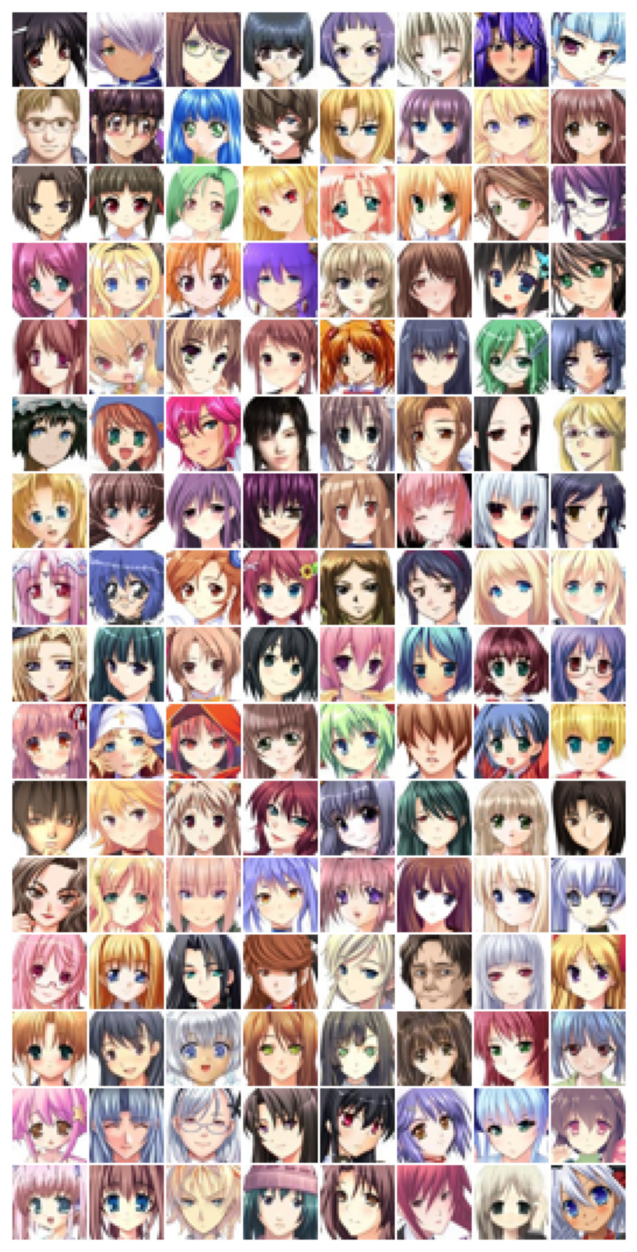

In [ ]:
loader = get_dataloader(
    dataset_name = BaseConfig.DATASET,
    batch_size = 128,
    device = 'cpu')
plt.figure(figsize = (8,16),facecolor = "white")

for b_image,_ in loader:
  b_image = denorm(b_image).cpu()
  grid_img = make_grid(b_image/255.0,nrow = 8,padding = True,pad_value = 1,normalize = True)
  plt.imshow(grid_img.permute(1,2,0))
  plt.axis("off")
  break

# Diffusion Process

In [ ]:
def get(tensor:torch.Tensor,time:torch.Tensor):
  tensor_at_t = tensor.gather(dim = -1,index = time)
  return tensor_at_t.reshape(-1,1,1,1)

In [ ]:
class SimpleDiffusion:
  def __init__(self,diffusion_time_step = 1000,device = 'cpu',image_shape = (3,64,64)):
    self.diffusion_time_step = diffusion_time_step
    self.device = device
    self.image_shape = image_shape
    self.initialize()

  def get_betas(self):
    betas = torch.linspace(start = 0.0001,end = 0.02, steps = self.diffusion_time_step,dtype = torch.float32,device = self.device)
    return betas

  def initialize(self):
    self.betas = self.get_betas()
    self.alphas = 1-self.betas
    self.beta_sqrt = torch.sqrt(self.betas)
    self.alpha_bar = torch.cumprod(self.alphas,dim = 0)
    self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
    self.one_by_sqrt_alpha = 1.0/torch.sqrt(self.alphas)
    self.sqrt_one_minus_alpha_bar = torch.sqrt(1-self.alpha_bar)

def forward_diffusion(sd:SimpleDiffusion,time:torch.Tensor,img:torch.Tensor):
  noise = torch.rand_like(img)
  sqrt_alpha_bar_t = get(sd.alpha_bar,time)
  sqrt_one_minus_alpha_bar_t = get(sd.sqrt_one_minus_alpha_bar,time)
  x = (sqrt_alpha_bar_t * img) + (sqrt_one_minus_alpha_bar_t*noise)
  return x,noise

# Sample Forward Diffusion Process

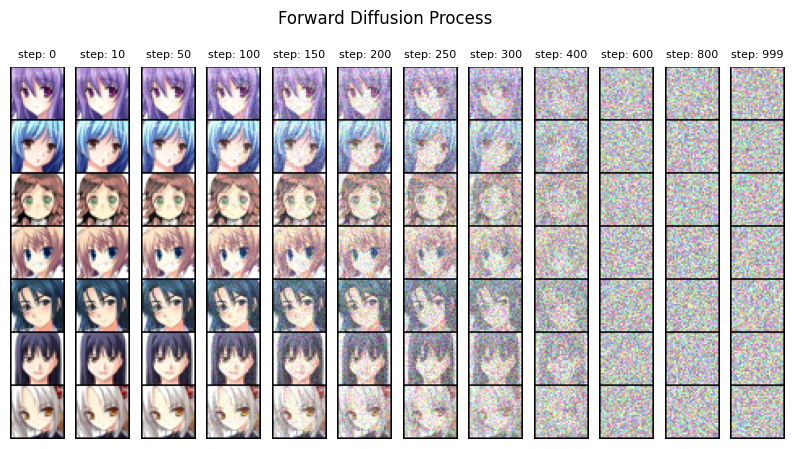

In [ ]:
sd = SimpleDiffusion(diffusion_time_step = TrainingConfig.TIMESTEPS,device = "cpu")
loader_iter = iter(get_dataloader(dataset_name = BaseConfig.DATASET,batch_size = 7,shuffle = True,device = "cpu"))

imgs,_ = next(loader_iter)

noisy_images = []

specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

for timesteps in specific_timesteps:
  time_step = torch.as_tensor(timesteps,dtype = torch.long)
  img_diffused,_ = forward_diffusion(sd,time_step,imgs)
  img_original = denorm(img_diffused) / 255.0
  grid_img_batch = make_grid(img_original,nrow = 1,padding = 1)
  noisy_images.append(grid_img_batch)

_,ax = plt.subplots(1,len(noisy_images),figsize = (10,6),facecolor = 'white')

for i,(timestep,noisy_image) in enumerate(zip(specific_timesteps,noisy_images)):
  ax[i].imshow(noisy_image.squeeze(0).permute(1,2,0))
  ax[i].set_title(f"step: {timestep}",fontsize = 8)
  ax[i].axis("off")
  ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=0.9)
plt.axis("off")
plt.show()


In [ ]:
@dataclass
class ModelConfig:
  BASE_CH = 64
  BASE_CH_MULTI = (1,2,4,8)
  APPLY_ATTENTION = (False,True,True,False)
  DROPOUT_RATE = 0.1
  TIME_EMB_DIMS = 64*4

# Warm Up for Training

In [ ]:
model = UNet(
    time_emb_dims               = ModelConfig.TIME_EMB_DIMS,
    in_channels                 = TrainingConfig.IMG_SHAPE[0],
    out_channels                = TrainingConfig.IMG_SHAPE[0],
    base_channels               = ModelConfig.BASE_CH,
    dropout_rate                = ModelConfig.DROPOUT_RATE,
    base_multiplier             = ModelConfig.BASE_CH_MULTI,
    apply_attention             = ModelConfig.APPLY_ATTENTION
)

model.to(BaseConfig.DEVICE)

optimizer = torch.optim.AdamW(params = model.parameters(),lr = TrainingConfig.LR)

dataloader = get_dataloader(dataset_name = BaseConfig.DATASET,
                            batch_size = TrainingConfig.BATCH_SIZE,

                            num_workers = TrainingConfig.NUM_WORKERS,
                            pin_memory = True,
                            device = BaseConfig.DEVICE)

loss_fn = nn.MSELoss()

sd = SimpleDiffusion(diffusion_time_step = TrainingConfig.TIMESTEPS,
                     device = BaseConfig.DEVICE,
                     image_shape = TrainingConfig.IMG_SHAPE)


scalar = amp.GradScaler()

<ipython-input-22-2a1b70bec26c>:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scalar = amp.GradScaler()


In [ ]:
training_epochs = TrainingConfig.NUM_EPOCHS + 1
log_dir,checkpoint_dir = setup_log_directory(config = BaseConfig())

generate_video = True
ext = ".mp4" if generate_video else ".png"

Logging at: ././Log_Checkpoints/Inference/version_0
Model Checkpoint at: ././Log_Checkpoints/Checkpoint/version_0


# Start Training

In [ ]:
# Algorithm for training for each batch in loader
def train_one_epoch(model,sd,loader,optimizer,scalar,loss_fn,epochs = 0,base_config = BaseConfig(),training_config = TrainingConfig()):
  loss_record = MeanMetric()
  model.train()

  with tqdm(total = len(loader),dynamic_ncols=True) as tq:
    tq.set_description(f"Train :: Epoch: {epochs}/{training_config.NUM_EPOCHS}")

    for x0s,_ in loader:
      tq.update(1)#updates the progress bar

      ts = torch.randint(low = 1,high = training_config.TIMESTEPS,size = (x0s.shape[0],),device = base_config.DEVICE)
      xts,gt_noise = forward_diffusion(sd,ts,x0s)

      with amp.autocast():
        pred_noise = model(ts,xts)
        loss = loss_fn(gt_noise,pred_noise)

      optimizer.zero_grad(set_to_none = True)
      scalar.scale(loss).backward()

      scalar.step(optimizer)
      scalar.update()

      loss_values = loss.detach().item()
      loss_record.update(loss_values)
      tq.set_postfix_str(s = f"Loss : {loss_values:.4f}")

    mean_loss = loss_record.compute().item()
    tq.set_postfix_str(s = f"Epoch Loss: {mean_loss:.4f}")

  return mean_loss


In [ ]:
#Algorithm 2 :Sampling
#timesteps:no of reverse time step
@torch.no_grad()
def reverse_diffusion(model,sd,timesteps = 1000,img_shape = (3,64,64),num_images = 5,nrow = 8,device = 'cpu',**kwargs):
  x = torch.randn((num_images,*img_shape),device=device)
  model.eval()

  if kwargs.get("generate_video", False):
    outs = []

  for time_step in tqdm(iterable = reversed(range(1,timesteps)),total = timesteps - 1,dynamic_ncols = False,desc = "Sampling::",position = 0):

    ts = torch.ones(num_images,dtype=torch.long,device = device)*time_step
    z = torch.randn_like(x) if time_step>1 else torch.zeros_like(x)

    predicted_noise = model(ts,x) #predicts the noise for each image in a particular time step

    beta_t = get(sd.betas,ts)
    one_by_sqrt_alpha_t = get(sd.one_by_sqrt_alpha,ts)
    sqrt_one_minus_alpha_t_bar = get(sd.sqrt_one_minus_alpha_bar,ts)

    x = (one_by_sqrt_alpha_t *(x - ((beta_t/sqrt_one_minus_alpha_t_bar)*predicted_noise))) + (torch.sqrt(beta_t) * z)

    if kwargs.get("generate_video", False):
      x_inv = denorm(x).type(torch.uint8)
      grid = make_grid(x_inv, nrow=nrow, pad_value=255.0).to("cpu")
      ndarr = torch.permute(grid, (1, 2, 0)).numpy()[:, :, ::-1]
      outs.append(ndarr)

  if kwargs.get("generate_video", False): # Generate and save video of the entire reverse process.
        video_frames(outs, kwargs['save_path'])
        display(Image.fromarray(outs[-1][:, :, ::-1])) # Display the image at the final timestep of the reverse process.
        return None

  else: # Display and save the image at the final timestep of the reverse process.
      x = denorm(x).type(torch.uint8)
      grid = make_grid(x, nrow=nrow, pad_value=255.0).to("cpu")
      pil_image = tf.functional.to_pil_image(grid)
      pil_image.save(kwargs['save_path'], format=save_path[-3:].upper())
      display(pil_image)
      return None


In [ ]:
for epochs in range(1,training_epochs):
  torch.cuda.empty_cache()
  gc.collect()

  train_one_epoch(model,sd,dataloader,optimizer,scalar,loss_fn,epochs=epochs)

  if epochs % 20 ==0:
    save_path = os.path.join(log_dir,f"{epochs}{ext}")
    # os.makedirs(save_path,exist_ok = True)

    reverse_diffusion(model,sd,timesteps=TrainingConfig.TIMESTEPS,img_shape = TrainingConfig.IMG_SHAPE,num_images=32,device=BaseConfig.DEVICE,generate_video = generate_video)

    # clear_output()
    checkpoint_dict = {
        "opt": optimizer.state_dict(),
        "scaler": scalar.state_dict(),
        "model": model.state_dict()
    }

    new_checkpoint_dir = os.path.join(checkpoint_dir,'ckpt.tar')
    os.makedirs(new_checkpoint_dir,exist_ok=True)
    torch.save(checkpoint_dict,new_checkpoint_dir)
    del checkpoint_dict


Train :: Epoch: 1/50:   0%|          | 1/1987 [00:00<06:20,  5.22it/s]<ipython-input-24-930f43256f5d>:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Train :: Epoch: 18/50:  70%|███████   | 1391/1987 [03:48<02:02,  4.85it/s, Loss : 0.0081]

# Inference

In [ ]:
model = UNet(
    time_emb_dims               = ModelConfig.TIME_EMB_DIMS,
    in_channels                 = TrainingConfig.IMG_SHAPE[0],
    out_channels                = TrainingConfig.IMG_SHAPE[0],
    base_channels               = ModelConfig.BASE_CH,
    dropout_rate                = ModelConfig.DROPOUT_RATE,
    base_multiplier             = ModelConfig.BASE_CH_MULTI,
    apply_attention             = ModelConfig.APPLY_ATTENTION
)
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "ckpt.tar"), map_location='cpu')['model'])

model.to(BaseConfig.DEVICE)

sd = SimpleDiffusion(diffusion_time_step = TrainingConfig.TIMESTEPS,
                     device = BaseConfig.DEVICE,
                     image_shape = TrainingConfig.IMG_SHAPE)

log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)

In [ ]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=128,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=8,
)
print(save_path)